In [1]:
#
# David Laziuk
# Graduate Group Project
#
# !!!!!!
# Only work done by myself is included
# !!!!!!
#

In [2]:
#Imports
import math
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import category_encoders as ce

In [3]:
#Loading Data
data=pd.read_csv('diabetic_data.csv',na_values= "?")
print("Original Shape: "+str(data.shape))
#Converting class to 0&1
data.loc[data['readmitted']=='NO','readmitted']=0
data.loc[data['readmitted']=='<30','readmitted']=1
data.loc[data['readmitted']=='>30','readmitted']=1
data['readmitted']=data['readmitted'].astype('int64')

#Manually classifing features
#encounter_id,patient_nbr,examide,citoglipton,metformin-rosiglitazone,
#weight,payer_code,medical_specialty are excluded as they will be dropped
#Numeric
num=['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency',
    'number_inpatient','number_diagnoses','age']
#Nominal Catagorical (Unordered)
nCat=['race','gender','admission_type_id','discharge_disposition_id','admission_source_id','diag_1','diag_2','diag_3','max_glu_serum',
     'A1Cresult','metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide',
      'glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','insulin',
      'glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-pioglitazone','change','diabetesMed']

data.head()

Original Shape: (101766, 50)


/var/folders/3d/157gtgxx7wq7dhrxg3x7l5g80000gn/T/ipykernel_17194/59811213.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv('diabetic_data.csv',na_values= "?")


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,0
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,1
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,0
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,0


In [4]:
#Drops
#Dropping encounter_id & patient_nbr as they are not relevant
data=data.drop(columns=['encounter_id'])
data=data.drop(columns=['patient_nbr'])

#Features "examide","citoglipton","metformin-rosiglitazone"
#Only contain "No", therefore they bring no value and will be dropped
data=data.drop(columns=['examide'])
data=data.drop(columns=['citoglipton'])
data=data.drop(columns=['metformin-rosiglitazone'])

#Dropping columns containing >40,000 NAs
na_count=data.isnull().sum(axis = 0)
print("All columns with NA's:")
for i in range(na_count.shape[0]):
    if(na_count.iloc[i]>0):
        print(str(na_count.index[i])+" "+str(na_count.iloc[i])
             +" "+str(round((na_count.iloc[i]/data.shape[0])*100,2))+"%")
print()
print("Columns to be dropped:")
for i in range(na_count.shape[0]):
    if(na_count.iloc[i]>40000):
        print(str(na_count.index[i]))
        data=data.drop(columns=[na_count.index[i]])
print("New Shape: "+str(data.shape))

#Dropping any remaining rows with NAs
data=data.dropna()
print("New Shape: "+str(data.shape))

del i,na_count
data.head()

All columns with NA's:
race 2273 2.23%
weight 98569 96.86%
payer_code 40256 39.56%
medical_specialty 49949 49.08%
diag_1 21 0.02%
diag_2 358 0.35%
diag_3 1423 1.4%

Columns to be dropped:
weight
payer_code
medical_specialty
New Shape: (101766, 42)
New Shape: (98053, 42)


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,...,No,No,Up,No,No,No,No,Ch,Yes,1
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,...,No,No,No,No,No,No,No,No,Yes,0
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,...,No,No,Up,No,No,No,No,Ch,Yes,0
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,...,No,No,Steady,No,No,No,No,Ch,Yes,0
5,Caucasian,Male,[50-60),2,1,2,3,31,6,16,...,No,No,Steady,No,No,No,No,No,Yes,1


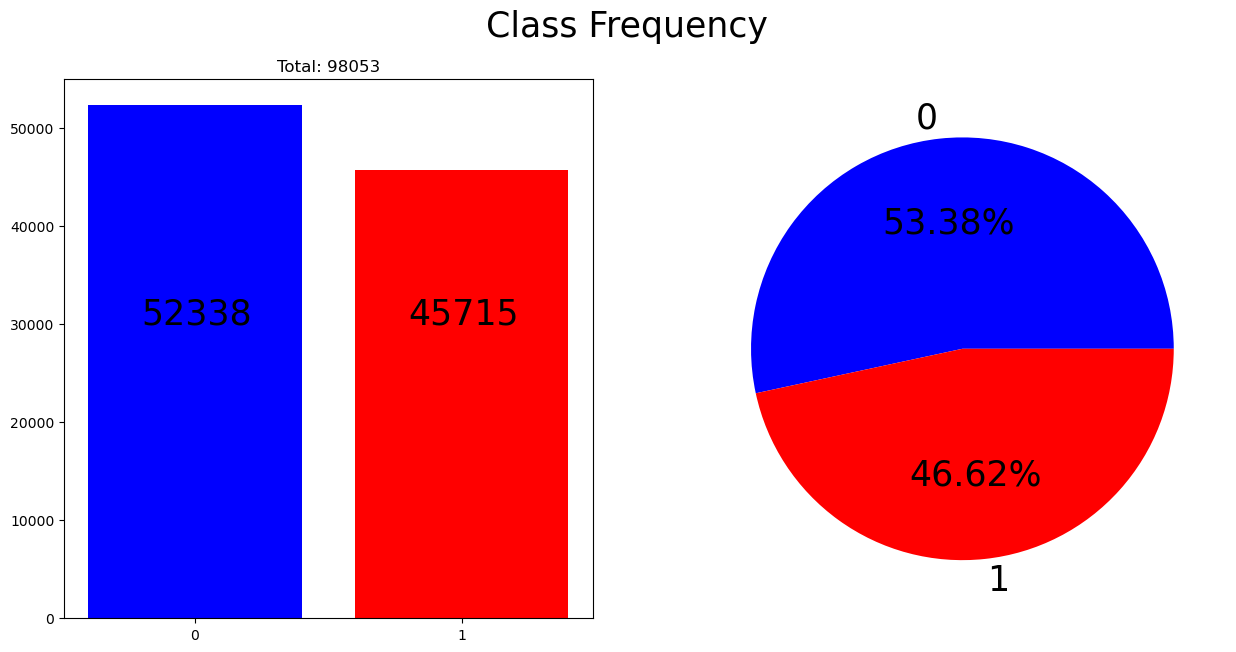

In [20]:
#Visualizing Class Frequency
comp=data['readmitted'].value_counts()
c0=comp[0]
c1=comp[1]
c0p=(c0/data.shape[0])*100
c1p=(c1/data.shape[0])*100
fig,(ax1,ax2)=plt.subplots(1, 2,figsize=(15,7))
ax1.bar(['0','1'],[c0,c1],color=['blue','red'])
ax1.text(-.2,30000,str(c0),color='black',fontsize=25)
ax1.text(.8,30000,str(c1),color='black',fontsize=25)
ax1.set_title('Total: '+str(c0+c1))
ax2.pie([c0p,c1p],labels=['0','1'],colors=['blue','red'],autopct='%1.2f%%',textprops={'fontsize': 25})
fig.suptitle('Class Frequency',fontsize=25)
plt.show()
del ax1,ax2,c0,c0p,c1,c1p,comp,fig

In [6]:
#Visualizing # of categories in each nominal feature
print("Number of categories in Nominal features:")
for c in nCat:
    comp=data[c].value_counts()
    print(c+": "+str(comp.shape[0]))
del c,comp

Number of categories in Nominal features:
race: 5
gender: 3
admission_type_id: 8
discharge_disposition_id: 26
admission_source_id: 17
diag_1: 713
diag_2: 740
diag_3: 786
max_glu_serum: 4
A1Cresult: 4
metformin: 4
repaglinide: 4
nateglinide: 4
chlorpropamide: 4
glimepiride: 4
acetohexamide: 2
glipizide: 4
glyburide: 4
tolbutamide: 2
pioglitazone: 4
rosiglitazone: 4
acarbose: 4
miglitol: 4
troglitazone: 2
tolazamide: 3
insulin: 4
glyburide-metformin: 4
glipizide-metformin: 2
glimepiride-pioglitazone: 2
metformin-pioglitazone: 2
change: 2
diabetesMed: 2


In [7]:
#Converting ordered catagorical to numerical (only age)
colI=data.columns.get_loc('age')
for r in range(data.shape[0]):
    val=str(data.iloc[r,colI])
    if(val=='[0-10)'):
        data.iloc[r,colI]=1
    elif(val=='[10-20)'):
        data.iloc[r,colI]=2
    elif(val=='[20-30)'):
        data.iloc[r,colI]=3
    elif(val=='[30-40)'):
        data.iloc[r,colI]=4
    elif(val=='[40-50)'):
        data.iloc[r,colI]=5
    elif(val=='[50-60)'):
        data.iloc[r,colI]=6
    elif(val=='[60-70)'):
        data.iloc[r,colI]=7
    elif(val=='[70-80)'):
        data.iloc[r,colI]=8
    elif(val=='[80-90)'):
        data.iloc[r,colI]=9
    else:  #val=='[90-100)'
        data.iloc[r,colI]=10
                
del colI,val,r
data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,Caucasian,Female,2,1,1,7,3,59,0,18,...,No,No,Up,No,No,No,No,Ch,Yes,1
2,AfricanAmerican,Female,3,1,1,7,2,11,5,13,...,No,No,No,No,No,No,No,No,Yes,0
3,Caucasian,Male,4,1,1,7,2,44,1,16,...,No,No,Up,No,No,No,No,Ch,Yes,0
4,Caucasian,Male,5,1,1,7,1,51,0,8,...,No,No,Steady,No,No,No,No,Ch,Yes,0
5,Caucasian,Male,6,2,1,2,3,31,6,16,...,No,No,Steady,No,No,No,No,No,Yes,1


In [8]:
#Binary-Encoding
for c in nCat:
    encoder= ce.BinaryEncoder(cols=[c],return_df=True)
    data=encoder.fit_transform(data) 
Y=data.loc[:,['readmitted']].values
data=data.drop(columns=['readmitted'])
data['readmitted']=Y
del Y,c,encoder
data.head()

,race_0,race_1,race_2,gender_0,gender_1,age,admission_type_id_0,admission_type_id_1,admission_type_id_2,admission_type_id_3,...,glipizide-metformin_1,glimepiride-pioglitazone_0,glimepiride-pioglitazone_1,metformin-pioglitazone_0,metformin-pioglitazone_1,change_0,change_1,diabetesMed_0,diabetesMed_1,readmitted
1,0,0,1,0,1,2,0,0,0,1,...,1,0,1,0,1,0,1,0,1,1
2,0,1,0,0,1,3,0,0,0,1,...,1,0,1,0,1,1,0,0,1,0
3,0,0,1,1,0,4,0,0,0,1,...,1,0,1,0,1,0,1,0,1,0
4,0,0,1,1,0,5,0,0,0,1,...,1,0,1,0,1,0,1,0,1,0
5,0,0,1,1,0,6,0,0,1,0,...,1,0,1,0,1,1,0,0,1,1


In [9]:
#Standardizing data
#Min max normalization will be used as many catagorical variables are present
for i in num:
    data[i]=(data[i]-data[i].min())/(data[i].max()-data[i].min())
del i
data.head()

,race_0,race_1,race_2,gender_0,gender_1,age,admission_type_id_0,admission_type_id_1,admission_type_id_2,admission_type_id_3,...,glipizide-metformin_1,glimepiride-pioglitazone_0,glimepiride-pioglitazone_1,metformin-pioglitazone_0,metformin-pioglitazone_1,change_0,change_1,diabetesMed_0,diabetesMed_1,readmitted
1,0,0,1,0,1,0.111111,0,0,0,1,...,1,0,1,0,1,0,1,0,1,1
2,0,1,0,0,1,0.222222,0,0,0,1,...,1,0,1,0,1,1,0,0,1,0
3,0,0,1,1,0,0.333333,0,0,0,1,...,1,0,1,0,1,0,1,0,1,0
4,0,0,1,1,0,0.444444,0,0,0,1,...,1,0,1,0,1,0,1,0,1,0
5,0,0,1,1,0,0.555556,0,0,1,0,...,1,0,1,0,1,1,0,0,1,1


In [10]:
#Ensuring data is float dtype
for c in range(int(data.shape[1]-1)):
    colname=data.columns[c]
    data[colname]=data[colname].astype(float)
del c,colname

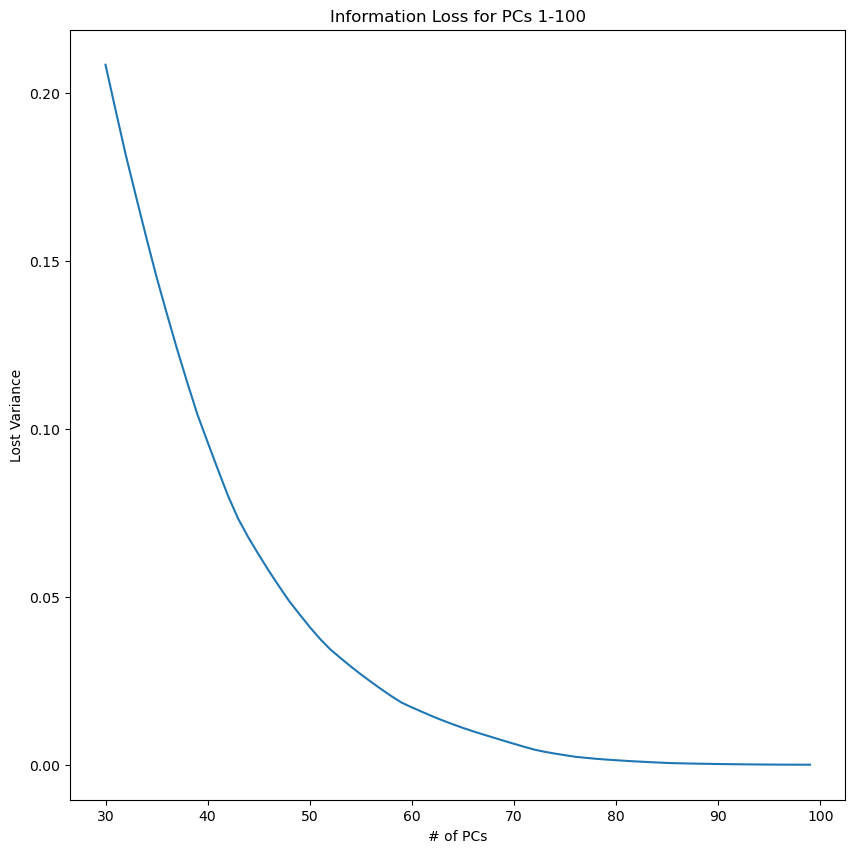

In [19]:
#Finding information loss for various # of PC's
variance=[]
num_pcs=[]
features=list(data.columns)
features.pop()
x=data.loc[:, features].values
y=data.loc[:,['readmitted']].values
for i in range(30,100):
    pca=PCA(n_components=i)
    PCs=pca.fit_transform(x)
    variance.append(1-(pca.explained_variance_ratio_).sum())
    num_pcs.append(i)
#Plotting information loss
plt.figure(figsize=(10,10))
plt.plot(num_pcs,variance,'-')
plt.xlabel('# of PCs')
plt.ylabel('Lost Variance')
plt.title("Information Loss for PCs 30-100")
del features,pca,PCs
plt.show()

In [21]:
#Computing PCA
pc_val=int(input("Please enter the desired amount of PCs: "))
idx=num_pcs.index(pc_val)
print("Lost Variance: "+str(variance[int(idx)]))
pca=PCA(n_components=pc_val)
PCs=pca.fit_transform(x)
colnames=[f'F{p}' for p in range(pc_val)]
pcDf=pd.DataFrame(PCs,columns=colnames)
Y=pd.DataFrame(y,columns=['readmitted'])
redData=pd.concat([pcDf,Y],axis=1)
#del PCA,PCs,Y,colnames,idx,num_pcs,pcDf,pc_val,pca,variance,x,y
redData.head()

Please enter the desired amount of PCs: 75
Lost Variance: 0.0028696285270516375


,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F66,F67,F68,F69,F70,F71,F72,F73,F74,readmitted
0,0.781183,-0.621737,0.104419,0.003967,-1.487942,0.350218,0.004744,0.035893,-0.605286,0.429674,...,-0.027941,-0.031518,0.072603,0.008963,-0.018677,-0.019751,-0.007256,-0.013137,-0.021369,1
1,-0.524056,-0.708847,0.389192,-0.373244,-0.770003,-0.550316,0.641497,-0.684159,0.105143,-0.452638,...,-0.019284,-0.021874,0.011194,-0.007561,0.006799,-0.033090,-0.007586,-0.007384,-0.020378,0
2,0.830243,-0.478317,-1.155320,0.289589,-0.832332,0.035193,0.220087,-0.350298,-0.604471,0.170633,...,-0.018729,-0.024592,0.045148,0.006159,-0.016147,-0.021240,-0.005565,-0.011049,-0.002421,0
3,0.717250,-0.279601,-1.116879,-0.769165,-0.582618,0.323920,-0.429963,-0.043884,0.529006,0.195134,...,0.001224,-0.009649,0.060809,-0.002949,-0.018004,-0.020491,-0.009685,-0.018365,-0.038457,0
4,-0.387677,1.245281,-0.966765,-0.636370,-1.072940,0.639332,-0.455939,0.045619,0.399413,0.970900,...,0.417289,-0.327177,-0.148300,-0.080989,0.064194,-0.075229,-0.009815,-0.013286,-0.068148,1


In [11]:
#Optional export
data.to_csv(r'/Users/davidlaziuk/Desktop/CS513 Project/FinalData.csv',index=False)

In [13]:
#
#
# Correlation EDA
#
#

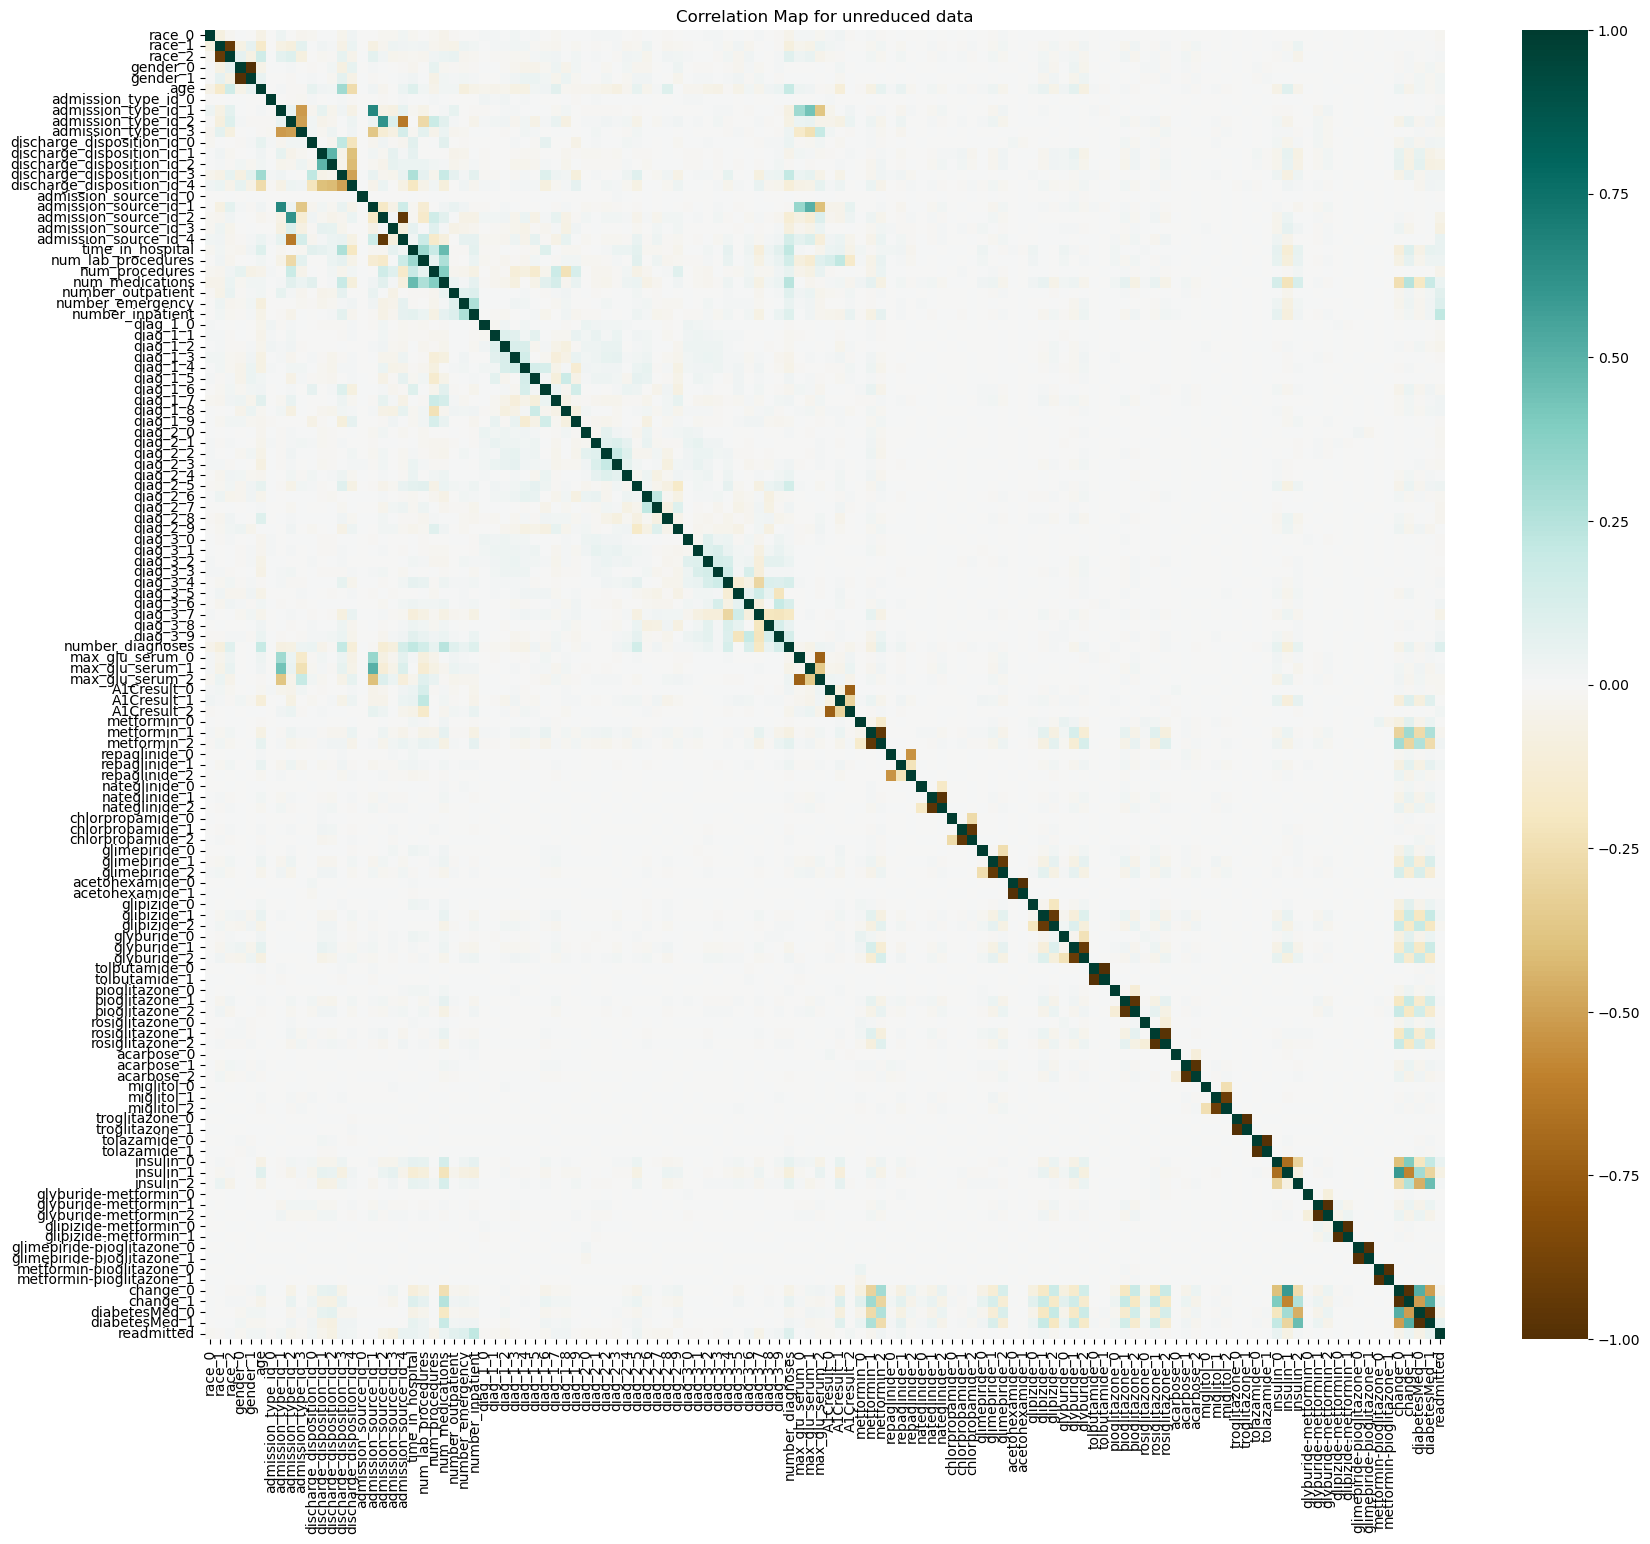

In [22]:
#NO PCA
rCorr=data.corr()
plt.figure(figsize=(20,17))
sns.heatmap(rCorr,vmin=-1, vmax=1, cmap='BrBG',xticklabels=True, yticklabels=True)
plt.title("Correlation Map for unreduced data")
plt.show()

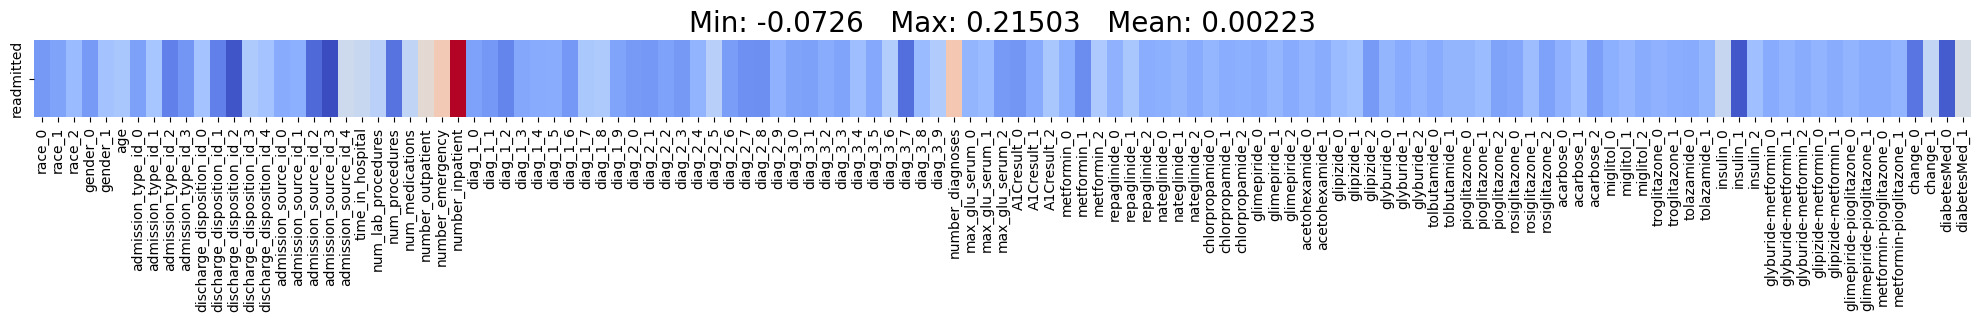

In [23]:
#Isolating last row (No PCA)
fCorr=rCorr.loc['readmitted',:]
fCorr=fCorr.drop(labels=['readmitted'])
fCorr=fCorr.to_frame()
fMin=float(fCorr.min())
fMax=float(fCorr.max())
fMean=float(fCorr.mean())
plt.figure(figsize=(25,1))
sns.heatmap(fCorr.T,vmin=fMin,vmax=fMax,cbar=False,cmap="coolwarm")
plt.title(("Min: "+str(round(fMin,5))+"   Max: "+str(round(fMax,5))+"   Mean: "+str(round(fMean,5))),fontsize=20)
plt.show()

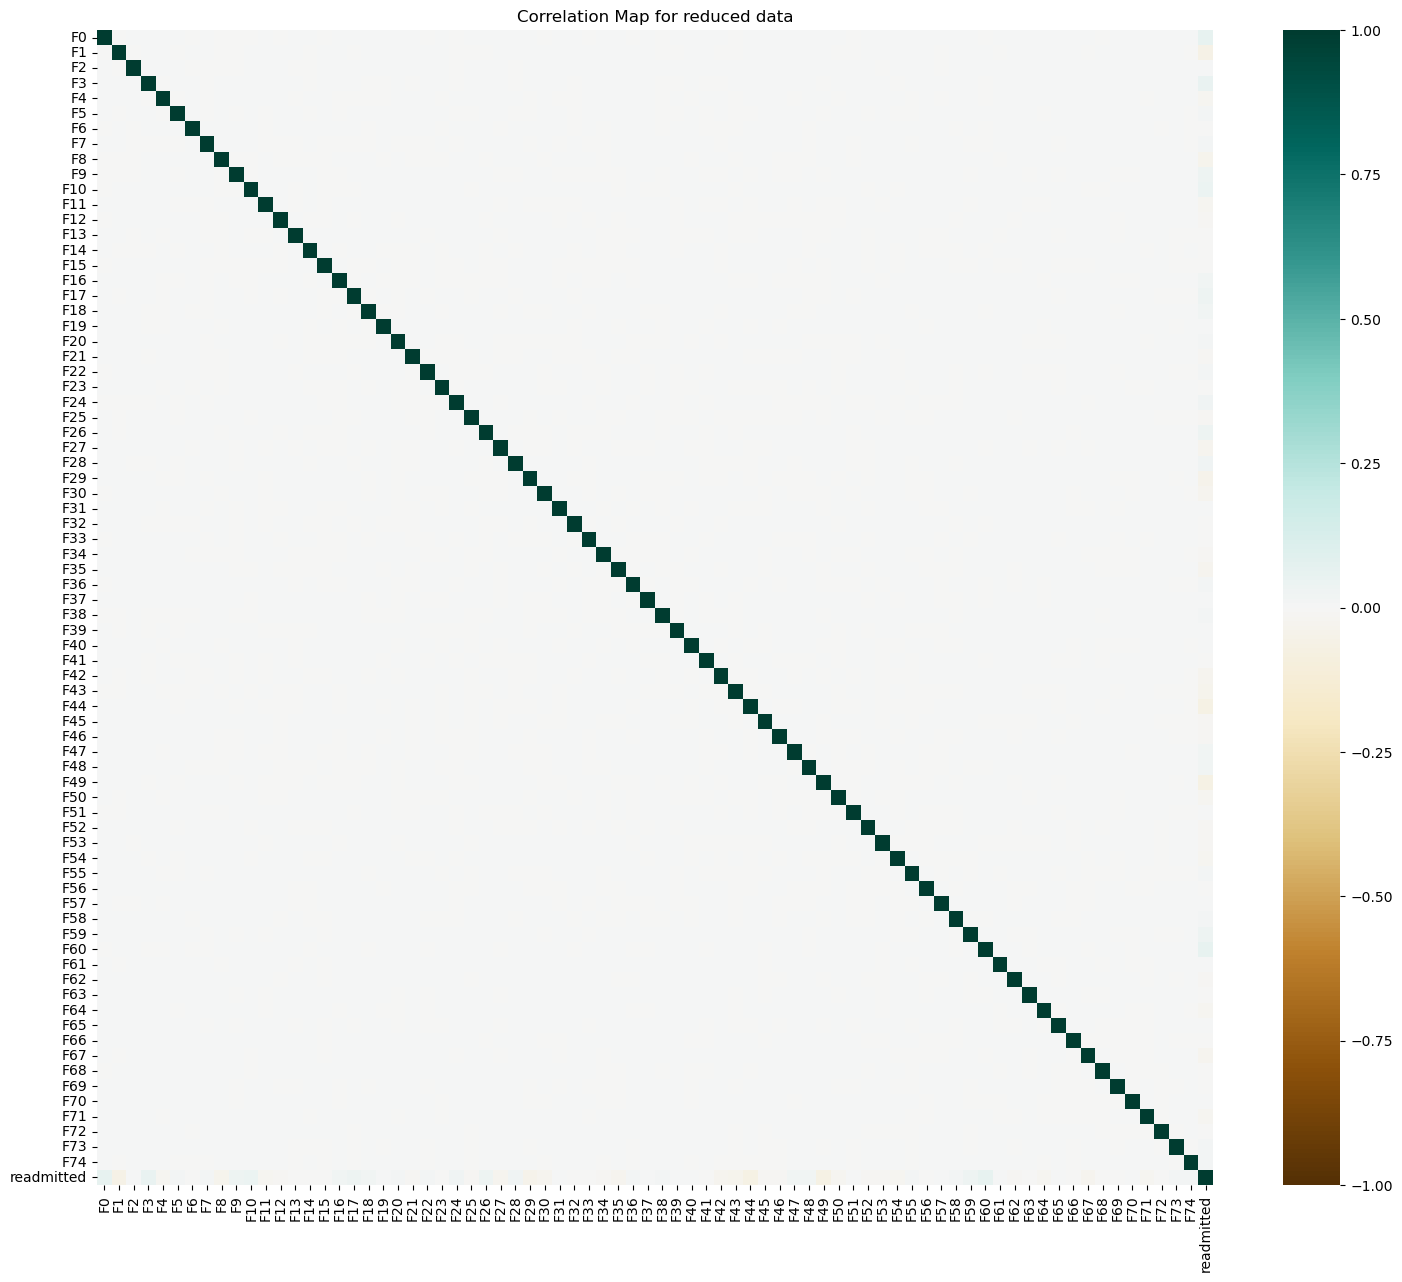

In [24]:
#Correlation EDA (PCA)
rCorr=redData.corr()
plt.figure(figsize=(18,15))
sns.heatmap(rCorr,vmin=-1, vmax=1, cmap='BrBG',xticklabels=True, yticklabels=True)
plt.title("Correlation Map for reduced data")
plt.show()

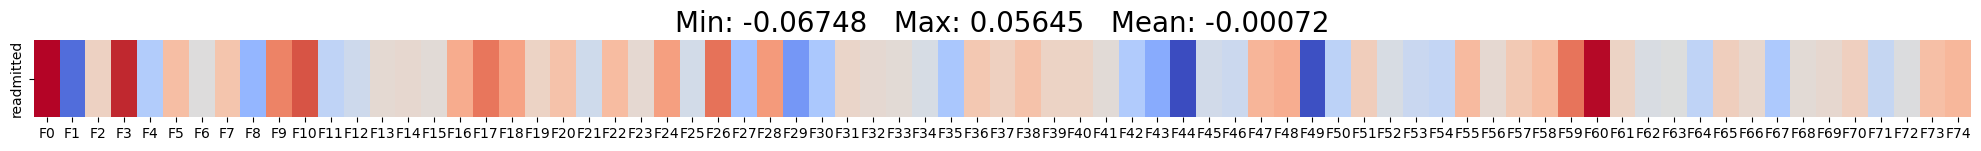

In [25]:
#Isolating last row(PCA)
fCorr=rCorr.loc['readmitted',:]
fCorr=fCorr.drop(labels=['readmitted'])
fCorr=fCorr.to_frame()
fMin=float(fCorr.min())
fMax=float(fCorr.max())
fMean=float(fCorr.mean())
plt.figure(figsize=(25,1))
sns.heatmap(fCorr.T,vmin=fMin,vmax=fMax,cbar=False,cmap="coolwarm")
plt.title(("Min: "+str(round(fMin,5))+"   Max: "+str(round(fMax,5))+"   Mean: "+str(round(fMean,5))),fontsize=20)
plt.show()